# K-means, Isolation Forest를 활용한 한전 주식 가격 이상치 찾기
## - 실패... 한 종목의 주식 트랜드(시계열 데이터)를 이와 같은 방식으로 이상치를 찾는 것은 무의미
## - 해당 시점의 주식 가격에 영향을 미치는 요소와 주식 가격을 함께 고려하여야함
## - open,close, high 등은 모두 동일한 다른 시점의 주식 가격으로, 주식가격에 영향을 주는 요소는 아님
## - MACD와 같은 방법 혹은 다른 방법으로 이상치를 찾아야함
## - 일정 과거 데이터에 비하여 변화가 큰 것을 찾는 방법으로 바꾸어야 함

In [59]:

import pyEX

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
#from pyemma import msm
%matplotlib inline

In [8]:
# pyex에서 주식 데이터 가져오기
# API token은 비공개
p = pyEX.Client('')

In [60]:
#한전의 5년치 주식 데이터
ticker = "KEP"
timeframe = '5y'
df = p.chartDF(ticker,timeframe)
df['index_'] = df.index
df_original = df
df.head()

,change,changeOverTime,changePercent,close,high,label,low,open,uClose,uHigh,uLow,uOpen,uVolume,volume,index_
date,,,,,,,,,,,,,,,
2014-07-07,0.00,0.000000,0.0000,18.46,18.66,"Jul 7, 14",18.37,18.55,18.46,18.66,18.37,18.55,102797,102797,2014-07-07
2014-07-08,-0.13,-0.007042,-0.7042,18.33,18.36,"Jul 8, 14",18.27,18.35,18.33,18.36,18.27,18.35,94421,94421,2014-07-08
2014-07-09,0.03,-0.005417,0.1637,18.36,18.38,"Jul 9, 14",18.20,18.20,18.36,18.38,18.20,18.20,150186,150186,2014-07-09
2014-07-10,0.52,0.022752,2.8322,18.88,18.94,"Jul 10, 14",18.69,18.85,18.88,18.94,18.69,18.85,189762,189762,2014-07-10
2014-07-11,-0.20,0.011918,-1.0593,18.68,18.75,"Jul 11, 14",18.68,18.73,18.68,18.75,18.68,18.73,107287,107287,2014-07-11


In [11]:
# 한전 자산 통계 정보
df1 = p.financialsDF(ticker)
df1.head()

,cashChange,cashFlow,costOfRevenue,currentAssets,currentCash,currentDebt,grossProfit,longTermDebt,netIncome,operatingExpense,...,operatingRevenue,researchAndDevelopment,shareholderEquity,shortTermDebt,totalAssets,totalCash,totalDebt,totalLiabilities,totalRevenue,symbol
reportDate,,,,,,,,,,,,,,,,,,,,,
2019-03-31,6.396731e+08,2.079082e+09,1.351752e+10,1.817280e+10,1.830872e+09,7.812442e+09,3.198552e+07,5.219634e+10,-7.000259e+08,1.411142e+10,...,1.354951e+10,1.380880e+08,6.072678e+10,7.812442e+09,1.687604e+11,4.893748e+09,6.000878e+10,1.068527e+11,1.354951e+10,KEP


In [12]:
# 한전의 Balance Sheet
df2 = p.balanceSheetDF(ticker)
df2.head()

,accountsPayable,capitalSurplus,commonStock,currentAssets,currentCash,currentLongTermDebt,goodwill,intangibleAssets,inventory,longTermDebt,...,propertyPlantEquipment,receivables,retainedEarnings,shareholderEquity,shortTermInvestments,totalAssets,totalCurrentLiabilities,totalLiabilities,treasuryStock,symbol
reportDate,,,,,,,,,,,,,,,,,,,,,
2019-03-31,2.527832e+09,1.830966e+09,2.827786e+09,1.817280e+10,1.830872e+09,7.063006e+09,2.274689e+06,1.150140e+09,6.104345e+09,5.219634e+10,...,1.389712e+11,5.458534e+09,1.254960e+10,6.072678e+10,3.062876e+09,1.687604e+11,2.034622e+10,1.068527e+11,None,KEP


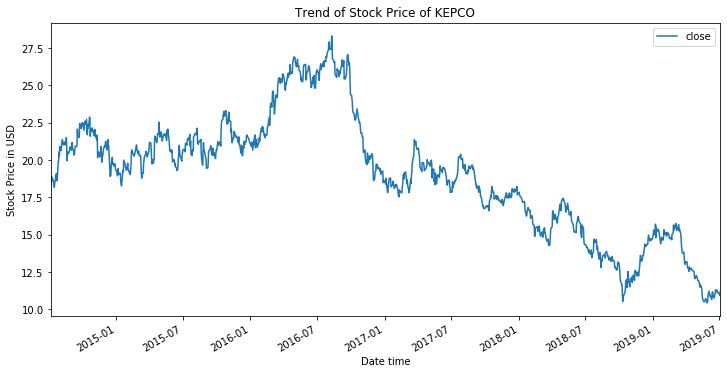

In [13]:
# 5년간 한전 주식의 종가
df.plot(y=['close'], figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Stock Price in USD')
plt.title('Trend of Stock Price of KEPCO');

In [ ]:
df.head()

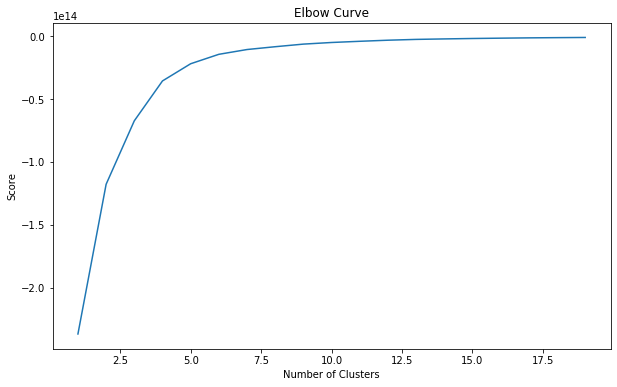

In [61]:
# K-means를 사용하기 위하여 클러스터 수를 짐작하기 위하여 Elbow Method 사용.
# 대략 7개의 클러스터 사용
data = df.loc[:, df.columns != 'label']
data = data.loc[:, data.columns != 'index_']
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();


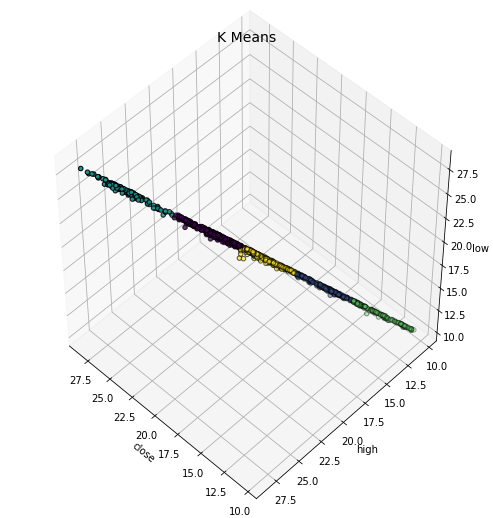

In [62]:
# 종가, 최고가격, 최저가격을 기준으로 클러스터링 결과 시각화
# 그림을 통해서 알 수 있는 것은 종가, 최고가격, 최저가격은 linear correlation이 있고, 비슷한 가격 기반으로 클러스터링이 됨.
# (이 케이스에서는 의미 없는 짓. 대부분 그날의 종가, 최고가격, 최저가격은 상관관계가 있기 때문)
X = df[['close', 'high', 'low']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("close")
ax.set_ylabel("high")
ax.set_zlabel("low")
plt.title("K Means", fontsize=14);

/home/rayjang/.local/lib/python3.6/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/rayjang/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


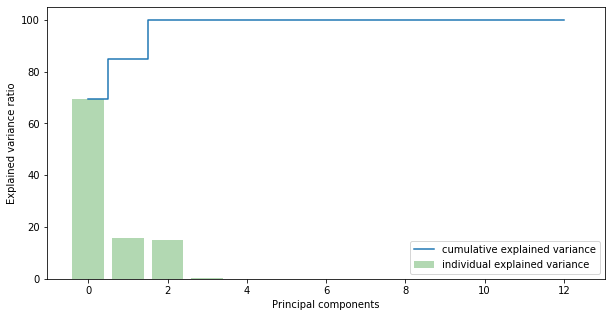

In [64]:
X = data.values
X_std = StandardScaler().fit_transform(X)
# 아이겐벡터와 아이켄벨류를 계산
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# (아이겐벨류, 아이겐벡터) 튜플 생성
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Explained Variance from the eigenvalues 계산
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();


In [65]:
# 데이터를 정규화함
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# PCA를 통하여 2개의 가장 중요한 features를 생성
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# 새로운 features를 정규화함
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [66]:
# 클러스터 개수를 5개로 해서 진행함.
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[5].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    346
3    330
2    305
4    163
1    113
5      1
Name: cluster, dtype: int64

/home/rayjang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


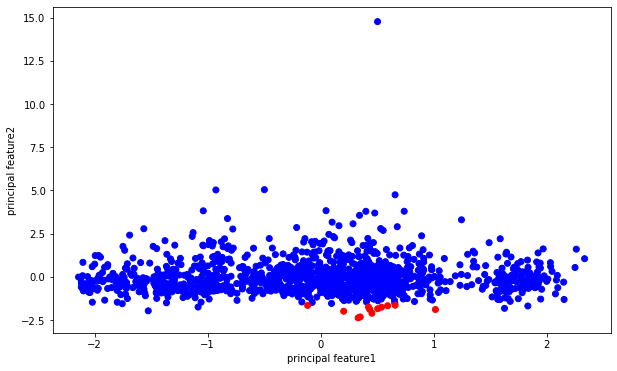

In [67]:

def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01 # 1%는 3 std와 같음
# 각 데이터와 가장 가까운 클러스터의 centroid와 거리를 계산함. 가장 큰 거리를 이상치로 간주
distance = getDistanceByPoint(data, kmeans[5])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [68]:
# 0은 정상, 1은 이상치의 개수를 의미
df.anomaly1.value_counts()

0    1246
1      12
Name: anomaly1, dtype: int64

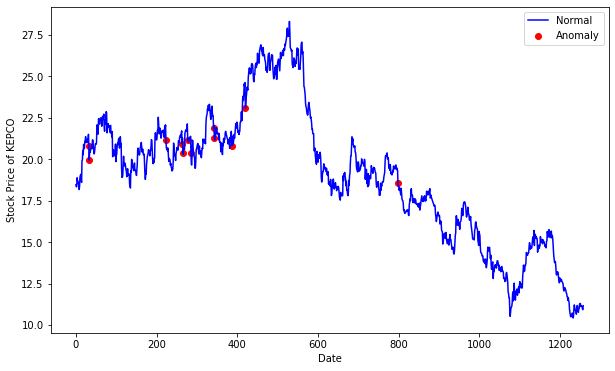

In [69]:
# 종가 기준으로 이상치라고 판단한 데이터를 빨간색으로 표기
df = df.sort_values('index_')
df['date_time_int'] = df.index.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'close']] #이상치

ax.plot(df['date_time_int'], df['close'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['close'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Stock Price of KEPCO')
plt.legend()
plt.show();
# 잘못나온 결과.. 무의미..

/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


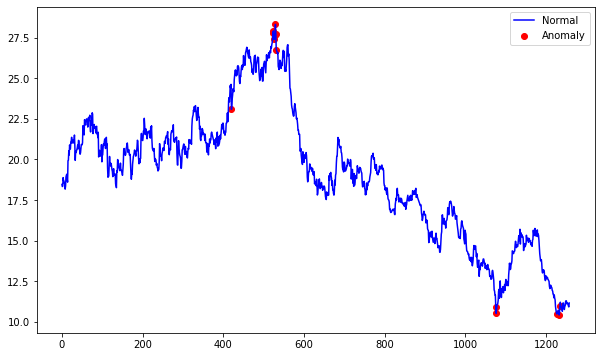

In [82]:
data = df.loc[:, df.columns != 'label']
data = data.loc[:, data.columns != 'index_']

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# isolation forest 학습
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly2'] = model.predict(data)

# Isolation Forest 시각화
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'close']] #anomaly

ax.plot(df['date_time_int'], df['close'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['close'], color='red', label = 'Anomaly')
plt.legend()
plt.show();
#


In [ ]:
# 시간과 종가만으로 이상치 탐색하기

In [34]:
df_original.head()

,change,changeOverTime,changePercent,close,high,label,low,open,uClose,uHigh,uLow,uOpen,uVolume,volume,index_
date,,,,,,,,,,,,,,,
2014-07-07,0.00,0.000000,0.0000,18.46,18.66,"Jul 7, 14",18.37,18.55,18.46,18.66,18.37,18.55,102797,102797,2014-07-07
2014-07-08,-0.13,-0.007042,-0.7042,18.33,18.36,"Jul 8, 14",18.27,18.35,18.33,18.36,18.27,18.35,94421,94421,2014-07-08
2014-07-09,0.03,-0.005417,0.1637,18.36,18.38,"Jul 9, 14",18.20,18.20,18.36,18.38,18.20,18.20,150186,150186,2014-07-09
2014-07-10,0.52,0.022752,2.8322,18.88,18.94,"Jul 10, 14",18.69,18.85,18.88,18.94,18.69,18.85,189762,189762,2014-07-10
2014-07-11,-0.20,0.011918,-1.0593,18.68,18.75,"Jul 11, 14",18.68,18.73,18.68,18.75,18.68,18.73,107287,107287,2014-07-11


/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


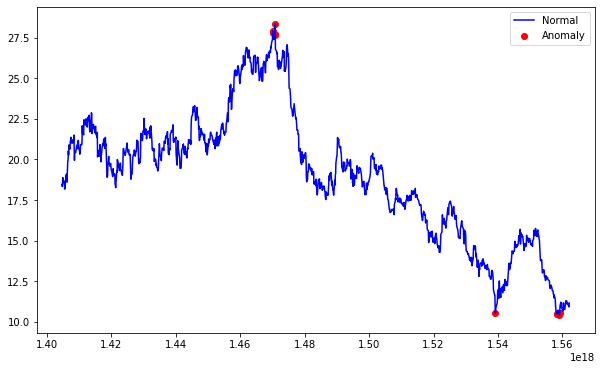

In [80]:
df_2 = df_original.sort_values('index_')
df_2['date_time_int'] = df_2.index.astype(np.int64)


data = df_2[['close', 'high','low','date_time_int']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df_2['anomaly2'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df_2.loc[df_2['anomaly2'] == -1, ['date_time_int', 'close']] #anomaly

ax.plot(df_2['date_time_int'], df_2['close'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['close'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [47]:
df_2.anomaly2.value_counts()

Series([], Name: anomaly2, dtype: int64)

In [50]:
# 주식 가격 변화율으로 이상치 탐색하기

/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/rayjang/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


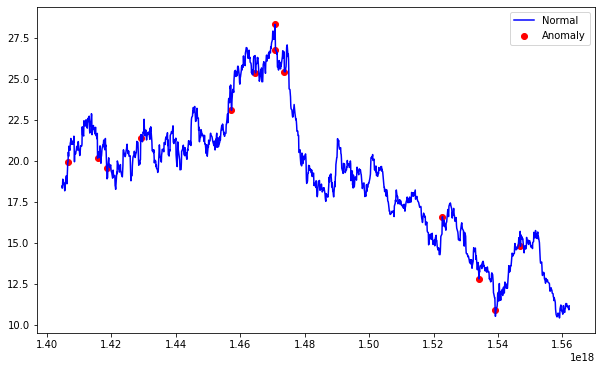

In [86]:
df_2 = df_original.sort_values('index_')
df_2['date_time_int'] = df_2.index.astype(np.int64)


data = df_2[['close', 'changePercent','changeOverTime','change']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
df_2['anomaly3'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df_2.loc[df_2['anomaly3'] == -1, ['date_time_int', 'close']] #anomaly

ax.plot(df_2['date_time_int'], df_2['close'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['close'], color='red', label = 'Anomaly')
plt.legend()
plt.show();